In [80]:
%pylab inline
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
%load_ext Cython
figsize(20,10)

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [81]:
import sys,os
sys.path.append('..')
sys.path.append('../..')
from backtester import matlab, backtester
from backtester.analysis import *
from backtester.swarms.swarm import Swarm
from backtester.exoinfo import EXOInfo
from backtester.swarms.rankingclasses import RankingClassBase, RankerBestWithCorrel
from exobuilder.data.exostorage import EXOStorage

import pandas as pd
import numpy as np
import scipy
import time
import glob
from pandas.tseries.offsets import *
import pprint

In [82]:
# Loading global setting for MongoDB etc.
from scripts.settings import *

try:
    from scripts.settings_local import *
except:
    pass

storage = EXOStorage(MONGO_CONNSTR, MONGO_EXO_DB)

In [83]:
swm_info = storage.swarms_info()
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(swm_info)

{   '_id': None,
    'alphas': ['MACross', 'RenkoPatterns_no_exit_on_patterns', 'SwingPoint'],
    'exo_types': ['CallSpread'],
    'instruments': ['ES']}


## Getting swarms using filter

In [84]:
instruments_filter = ['*']  # Select ALL
#instruments_filter = ['ES', 'CL']

exo_filter = ['*'] # Select ALL
#exo_filter = ['BullishCollar']

direction_filter = [0, -1, 1] # Select ALL
#direction_filter = [1]

alpha_filter = ['*']  # Select ALL
#alpha_filter = ['MaCross', 'PointAndFigurePatterns']

swmdf, swm_data = storage.swarms_list(instruments_filter, direction_filter, alpha_filter, exo_filter)

## Set ranking params

In [85]:
rank_correl_threshold = 0.5 # Default = 0.5
rank_window_size = 10       # Default = -1

## Processsing swarm ranks

In [86]:
def process_swarm_rank(swarm_filename):    
    swm = Swarm.load(filename=swarm_filename)
    print("Loading: {0}".format(swm.name))
    swm.context['swarm']['ranking_class'] = RankerBestWithCorrel(window_size=rank_window_size,
                                                                 correl_threshold=rank_correl_threshold)


    old_picked_equity = swm.picked_equity
    swm.pick()
    new_picked_equity = swm.picked_equity
    raw_equity = swm.raw_equity

    eq_df = pd.DataFrame({'new': new_picked_equity, 'old': old_picked_equity, 'raw': raw_equity})
    delta = eq_df['new'] - eq_df['old']
    
    eq_stats = {
        'avg_delta': delta.mean()
    }
    
    return swm.name, eq_df, eq_stats

In [87]:
TMQRPATH = os.getenv("TMQRPATH", '')
print('Swarms List')

swarms_equities = {}
swarms_stats = {}
for file in swmdf.columns:
    swarm_name = file.replace('.swm','')
    fn = os.path.join(TMQRPATH, 'swarms', file + '.swm')
    try:
        swarm_name, swarm_eq, swarm_stat = process_swarm_rank(fn)        
        swarms_equities[swarm_name] = swarm_eq
        swarms_stats[swarm_name] = swarm_stat
    except FileNotFoundError:
        print('{0} not found'.format(fn))
        
swarm_stats = pd.DataFrame(swarms_stats).T

Swarms List
Loading: ES_CallSpread_Long_MACross
Loading: ES_CallSpread_Long_SwingPoint
Loading: ES_CallSpread_Short_MACross
Loading: ES_CallSpread_Short_RenkoPatterns_no_exit_on_patterns
Loading: ES_CallSpread_Short_SwingPoint


## Calculating difference between new and old equities

##### Note: greater value of avg_delta means that NEW ranking parameters better than default

delta = new_equity - old_equity

avg_delta = mean(delta)

In [88]:
pd.DataFrame(swarms_stats).T

,avg_delta
ES_CallSpread_Long_MACross,-173.678456
ES_CallSpread_Long_SwingPoint,0.000000
ES_CallSpread_Short_MACross,36.495629
ES_CallSpread_Short_RenkoPatterns_no_exit_on_patterns,37.764734
ES_CallSpread_Short_SwingPoint,92.141537


## Graph of equity deltas for each swarm

##### Note: greater value of delta means that NEW ranking parameters better than default

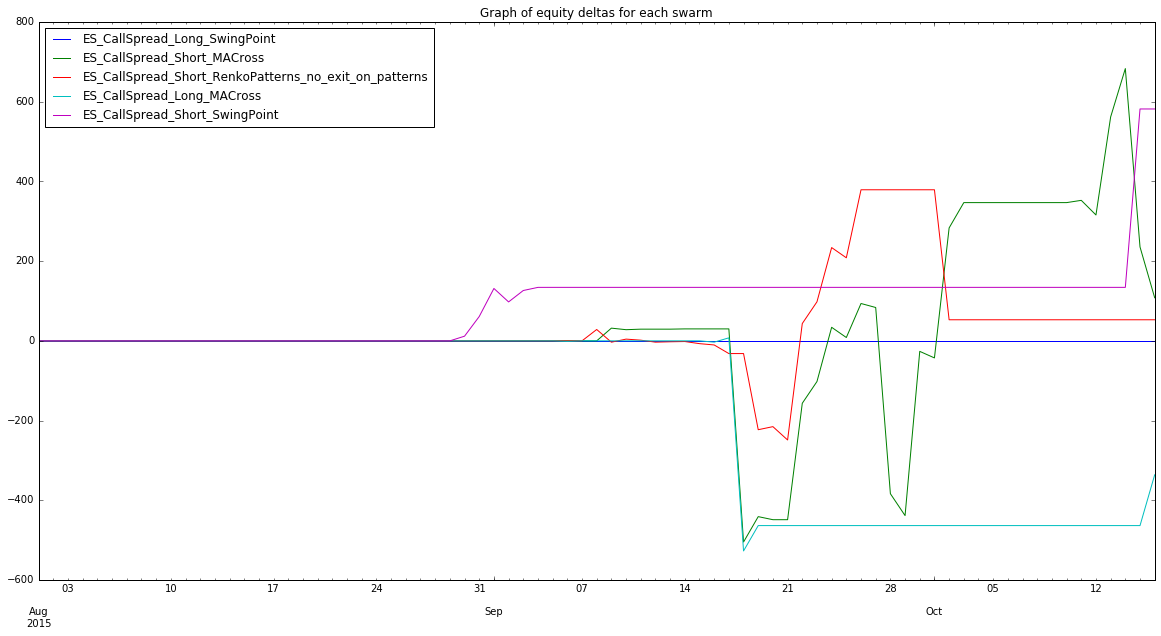

In [89]:
for s, eq_df in swarms_equities.items():
    delta  = eq_df['new'] - eq_df['old']
    
    delta.plot(label=s)
legend(loc=2);
title('Graph of equity deltas for each swarm');

## Pairwise graphs for all swarms

#### Note: 'raw' equity line (red) is an average of all swarm equities

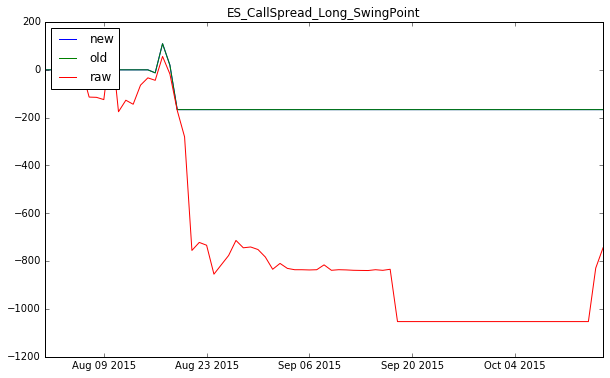

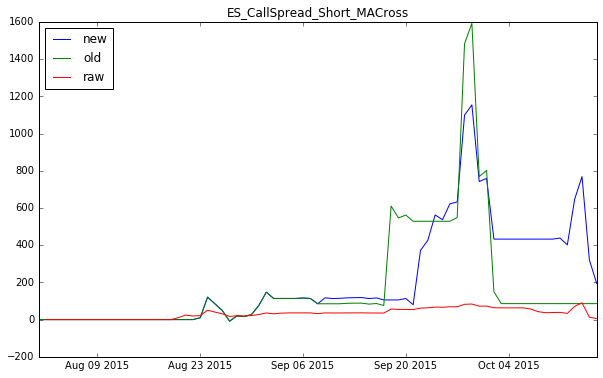

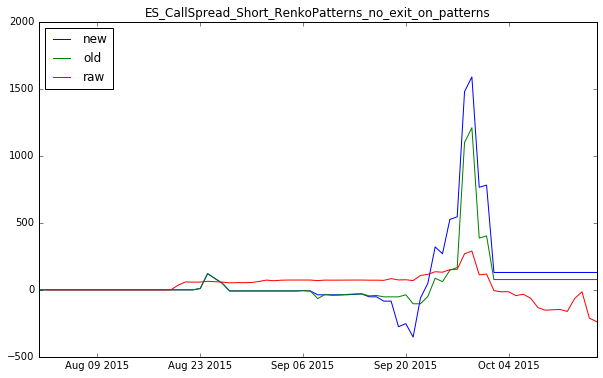

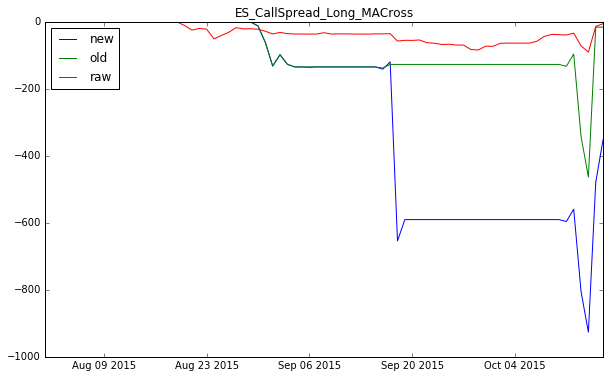

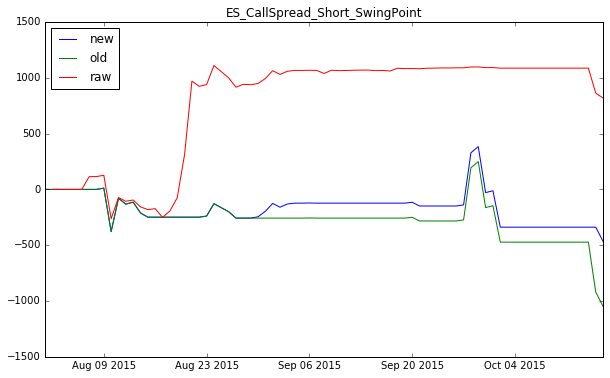

In [111]:
figsize(10, 6)
fig_index = 1
for s, eq_df in swarms_equities.items():
    f = plt.figure(fig_index)
    plt.plot(eq_df['new'], label='new');
    plt.plot(eq_df['old'], label='old');
    plt.plot(eq_df['raw'], label='raw');
    plt.legend(loc=2)
    plt.title(s);
    fig_index += 1
